# Visual Inspection of Motorcycle Connecting Rods

## Second task

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

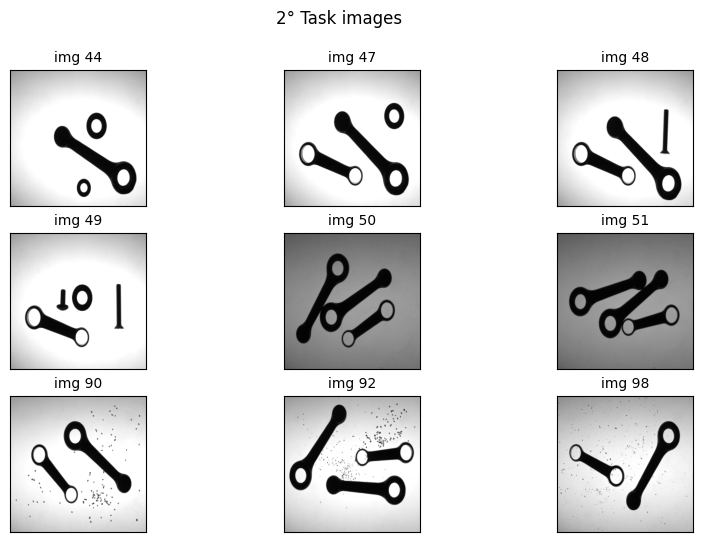

In [3]:
# image loading
image_numbers = ["44","47","48","49","50","51", "90", "92", "98"]
images = []

for x in image_numbers:
    img_path = "img/TESI" + f"{x}" + ".BMP"
    image_x = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    images.append(image_x)

################# plots #################

fig1, axes1 = plt.subplots(3, 3, figsize=(10, 6))
# plotting images in 3x2 subplots figure
for i, ax in enumerate(axes1.flat):
    ax.imshow(images[i], cmap='gray', vmin=0, vmax=255)
    ax.set_title(f"img {image_numbers[i]}", fontsize=10)
    # hiding axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

fig1.suptitle("2° Task images")
plt.show()  # show full figure

First off, implementing the code deployed in the first task:

In [4]:
# starting with used functions

def linear_stretching(img, max_value, min_value):
    img[img<min_value] = min_value
    img[img>max_value] = max_value
    linear_stretched_img = 255./(max_value-min_value)*(img-min_value)
    return linear_stretched_img


def find_percentile_value(hist, percentile):
    s = 0
    idx = 0
    total_pixel = np.sum(hist)
    while(s < total_pixel*percentile/100):
        s += hist[idx]
        idx += 1
    return idx

def getDistance(p1,p2):
    if (not isinstance(p1, tuple) or not isinstance(p2, tuple)):
        print("wrong input in getDistance()")
        return 0

    x1,y1 = tuple(map(float,p1))
    x2,y2 = tuple(map(float,p2)) 
    dist = np.sqrt(np.square(abs(x1-x2))+np.square(abs(y1-y2)))
    return dist

def getRodTypes(rods, holes):
    if (not isinstance(rods, list) or not isinstance(holes, list)):
        print("wrong input in getRodTypes()")
        return 0
    
    types = []
    rods_holes_count = {}
    for j, rod in enumerate(rods):   
        rods_holes_count[j] = 0
        
    for i, hole in enumerate(holes):   
        min_dist  = 360.   
        found_rod = -1    
        
        for j, rod in enumerate(rods):
            if (getDistance(rod[0],hole[0]) <= min_dist):
                min_dist  = getDistance(rod[0],hole[0])
                found_rod = j
                rods_holes_count[found_rod] += 1

    for k in range(len(rods)):  
        if (rods_holes_count[k] < 2):
            types.append('A')   # A is 1 hole rod
        else:
            types.append('B')   # B is 2 holes rod

    return types

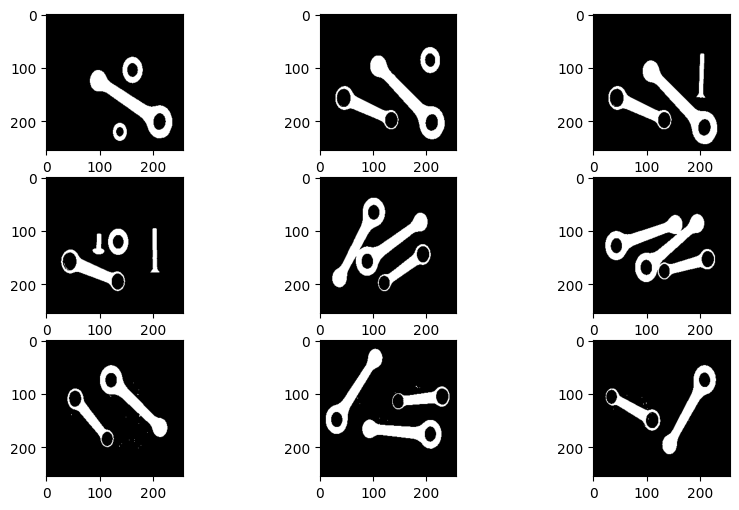

In [5]:
# 1° step: linear dynamic stretching ------------------------------------------------------------------------
histograms = [0] * len(images)   
bins = [0] * len(images)        
    
for j, img in enumerate(images):
    histograms[j], bins[j] = np.histogram(img.flatten(), 256, [0,256])
    
images_st = []
histograms_st = [0] * len(images)
bins_st = [0] * len(images)

for i, img in enumerate(images):
    max_value = find_percentile_value(histograms[i], 15)  
    min_value = find_percentile_value(histograms[i], 1)
    linear_stretched_img = linear_stretching(np.copy(images[i]), max_value,min_value)
    images_st.append(linear_stretched_img)
    histograms_st[i], bins_st[i] = np.histogram(linear_stretched_img.astype(np.uint8).flatten(),256,[0,256])

# 2° step: applying bilateral filter for noise removal -----------------------------------------------------
gf_images = []
for i, img in enumerate(images_st):
    temp_img = cv2.bilateralFilter(np.copy(img).astype(np.uint8), 80, 100, 10)
    gf_images.append(temp_img)

# 2b° step: converting images to 1-bit depth & morph transformations -----------------------------------------
images_bin = []

for i, img in enumerate(gf_images):
    rettresh, bin_img = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
    bin_img = np.clip(bin_img, 0, 255).astype(np.uint8)  
    inv_img = cv2.bitwise_not(bin_img)
    images_bin.append(inv_img)

fig1, axes1 = plt.subplots(3, 3, figsize=(10, 6))
for i, ax in enumerate(axes1.flat):
    ax.imshow(images_bin[i], cmap='gray', vmin=0, vmax=255)

plt.show()

In [6]:
# 3° step: object identification ----------------------------------------------------------------------------
components = []           
labeled_blank_images = []

for i, img in enumerate(images_bin):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(images_bin[i].astype(np.uint8), connectivity=8, ltype=cv2.CV_32S)
    components.append([num_labels, labels, stats, centroids])
    labeled_blank_images.append(labels.astype(np.uint8))

# 4° step: contour extraction -------------------------------------------------------------------------------
cnt_full_images = {}   
cnt_full_dict = {}

for i, img in enumerate(labeled_blank_images): 
    temp_img = np.copy(img)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(temp_img, contours, -1, (255,255,255), 2)
    cnt_full_images[i] = temp_img
    cnt_full_dict[i]   = contours

# 5° step: oriented bounding box ----------------------------------------------------------------------------
rect_dict = {}

def getMER(cnt_full_images,cnt_full_dict,rect_dict):
    for i, cnt in enumerate(cnt_full_dict):
        rect_dict[i] = [] 
        img_copy = np.copy(cnt_full_images[i])  
        
        for j in range(len(cnt_full_dict[i])):            
            rect = cv2.minAreaRect(cnt_full_dict[i][j])   # min rect for each component 
            center, (width, height), angle = rect         # tuple(x,y), tuple(w,h), float
            rect_dict[i].append(rect)

getMER(cnt_full_images,cnt_full_dict,rect_dict)

extra: Closing and eroding images with blocks of rods - disabled

In [12]:
# 6° step: area thresholding and rod type recognition --------------------------------------------------------

MER_dict = {}
treshold_block = 40000   # old 20000
treshold_rod   = 1830   # old 2000  
treshold_hole  = 270   # old 150

for i in range(len(rect_dict)):
    MER_dict[i] = []
    rods  = []
    holes = []

    for j, MER in enumerate(rect_dict[i]):   
        area = MER[1][0] * MER[1][1] 
        # print(f"img {i} part {j} area {area}")
        if (area < treshold_block): 
            if (area < treshold_rod):
                if (area < treshold_hole):
                    # print(f"removing part{j}")
                    rect_dict[i].pop(j)
                else:
                    holes.append(MER)
            else:
                rods.append(MER)
        # else:                                      
            # print(f"found very big area: {area} - running closeAndErode({i})")
            # closeAndErode(i)

    MER_dict[i].append(rods)
    MER_dict[i].append(holes)
    print("\n")

for i in range(len(MER_dict)):
    MER_dict[i].append(getRodTypes(MER_dict[i][0],MER_dict[i][1]))

In [13]:
# Width at barycenter

def computeWb(img_index):
    bar_pos_img = []
    Wbs = []
    for i, rod in enumerate(MER_dict[img_index][0]):   # iterating all the rods in the image
        bar_pos = rod[0]   # accessing and storing barycenter position in the list
        bar_pos_img.append(bar_pos)
        
        # line equation (perpendicular to major axis orientation)
        angle = rod[2]   # (0, 90] rotating clockwise
        width, length = rod[1]        
        if ( width < length):   # check for major axis orientation (linked with how the angle is computed by cv2.minAreaRect)
            angle += 90

        slope = np.tan(np.radians(angle + 90))
        q = bar_pos[1] - slope*bar_pos[0]   # q = Yc - mXc

        # constraints of the line in a neighbour of the barycenter (assuming that the width of the rod is <= W_MAX, the square identified in the x,y 
        # region around the barycenter is the maximum draw region for each line. Thus hopefully avoiding intersection with other rods in the image.
        W_MAX = 15
        x_min = int(bar_pos[0]) - W_MAX
        y_min = int(bar_pos[1]) - W_MAX  
        x_max = int(bar_pos[0]) + W_MAX
        y_max = int(bar_pos[1]) + W_MAX  
        
        points = []
        pixel_count = 0
        for x in range(x_min, x_max+1):   # iterating all the x coordinates in the image, in the neighbour of the barycenter
            y_eq = int(np.round(slope*x + q))
            # y_eq = np.clip(y_eq, y_min, y_max)   # solve overflow for almost vertical lines with high slope
            if (np.abs(y_eq) > y_max):   # skipping saturated segments (this might be a problem for slopes -> inf) - either this or np.clip to avoid 'out of boud'
                continue
                
            val_x = images_bin[img_index][y_eq,x]
            if (val_x == 255):
                points.append((x,y_eq))
                pixel_count += 1


        Wb = pixel_count
        Wbs.append(Wb)   # all the width at barycenter for all the rods in the img_index image.
        pixel_count = 0

    return Wbs

##############################################
# attaching the width at barycenter in another dict
wb_dict = {}

for i in range(len(images)):
    wb_dict[i] = []
    temp_wbs = computeWb(i)
    # print(temp_wbs)
    for j, rod in enumerate(MER_dict[i][0]):
        wb_dict[i].append(temp_wbs[j])

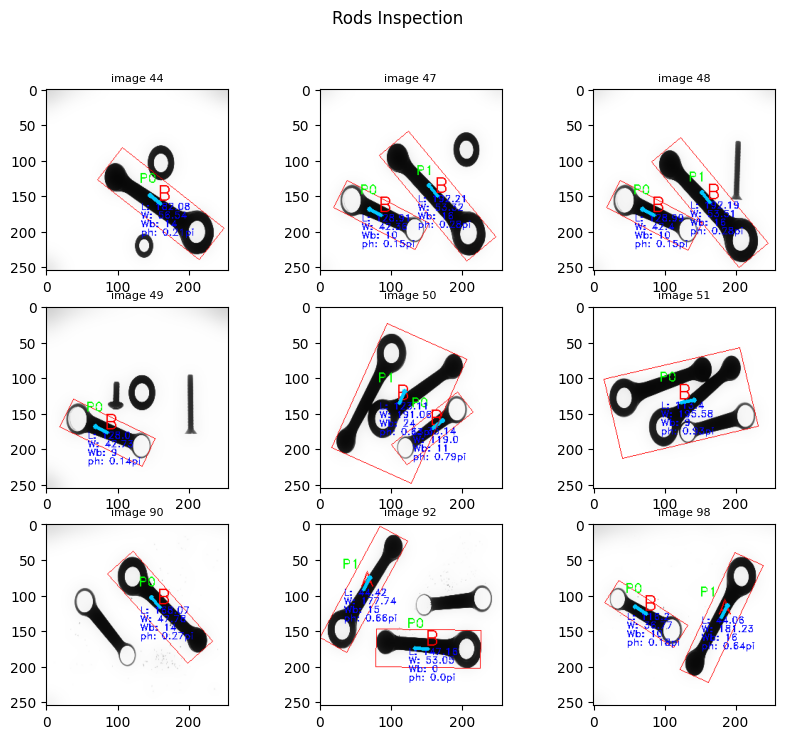

In [14]:
# 7° step: visualization -------------------------------------------------------------------------------------
fig, axes = plt.subplots(int(np.ceil(len(images)/3)), 3, figsize=(10, 8))
fig.suptitle("Rods Inspection")

for i in range(len(images)):
    img_copy  = np.copy(gf_images[i])
    img_color = cv2.merge([img_copy, img_copy, img_copy])

    for j, rod in enumerate(MER_dict[i][0]):
        box = np.intp(cv2.boxPoints(rod))   
        cv2.drawContours(img_color, [box], -1, (255,0,0), 1)
        cv2.putText(img_color, f"P{j}", org=tuple(map(np.intp, tuple(np.subtract(rod[0],30)))), fontFace=2, fontScale=0.6, color=(0,255,0))
        cv2.putText(img_color, MER_dict[i][2][j], org=tuple(map(np.intp, tuple(np.subtract(rod[0],5)))), fontFace=2, fontScale=1, color=(255,0,0))
        cv2.putText(img_color, f"L: {round(rod[1][0],2)}", org=tuple((int(rod[0][0])-28, int(rod[0][1])+8)), fontFace=2, fontScale=0.45, color=(0,0,255))
        cv2.putText(img_color, f"W: {round(rod[1][1],2)}", org=tuple((int(rod[0][0])-28, int(rod[0][1])+20)), fontFace=2, fontScale=0.45, color=(0,0,255))
        cv2.putText(img_color, f"Wb: {wb_dict[i][j]}", org=tuple((int(rod[0][0])-28, int(rod[0][1])+32)), fontFace=2, fontScale=0.45, color=(0,0,255))

        
        x = rod[0][0]
        y = rod[0][1]
        
        # ending point of arrow oriented along major axis
        theta = rod[2]
        width, length = rod[1]
        line_length = 20    
        
        if (width < length):   # check for major axis orientation
            theta += 90
        
        x2 = x + line_length*np.cos(np.radians(theta+180))   # note: argument of np.cos/sin is in radians
        y2 = y + line_length*np.sin(np.radians(theta+180))
        
        cv2.putText(img_color, f"ph: {round(np.radians(theta)/np.pi,2)}pi", org=tuple((int(rod[0][0])-28, int(rod[0][1])+44)), fontFace=2, fontScale=0.45, color=(0,0,255))   # inserted modulo-pi notation with np.pi
        cv2.arrowedLine(img_color, tuple(map(int, rod[0])), (int(x2), int(y2)), (0,200,255), 4)
    
    axes.flat[i].imshow(img_color)
    axes.flat[i].set_title(f"image {image_numbers[i]}", size=8)
        
plt.show()